0
Writing data 0: 0
Measurement outputs : -11.2265
Expected Output : -11.249923706054688
Writing data 65535: 65535
Measurement outputs : 11.2499
Expected Output : 11.249732971191406

Data stored in DataFrame:
    CODE  VOUT - EXPECTED  VOUT-RESULT     Error
0      0       -11.249924     -11.2265 -0.023424
1  65535        11.249733      11.2499 -0.000167


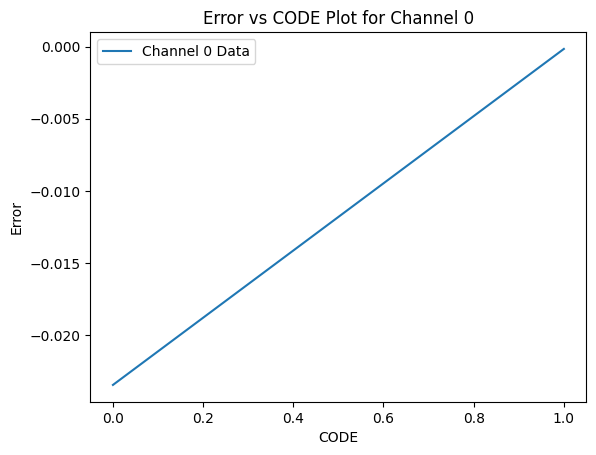

1
Writing data 0: 0
Measurement outputs : -11.2418
Expected Output : -11.249923706054688
Writing data 65535: 65535
Measurement outputs : 11.2436
Expected Output : 11.249732971191406

Data stored in DataFrame:
    CODE  VOUT - EXPECTED  VOUT-RESULT     Error
0      0       -11.249924     -11.2418 -0.008124
1  65535        11.249733      11.2436  0.006133


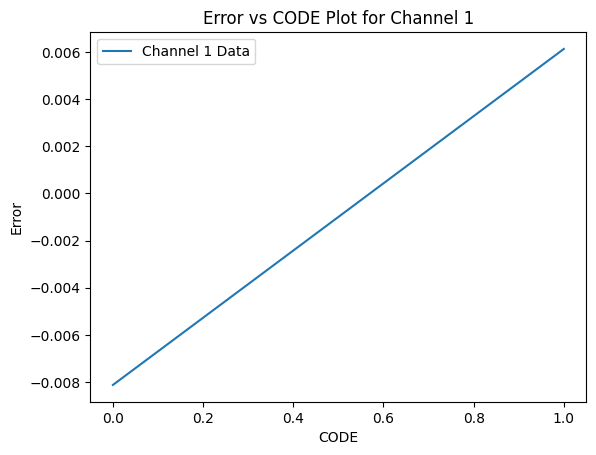

2
Writing data 0: 0
Measurement outputs : -11.2185
Expected Output : -11.249923706054688
Writing data 65535: 65535
Measurement outputs : 11.2562
Expected Output : 11.249732971191406

Data stored in DataFrame:
    CODE  VOUT - EXPECTED  VOUT-RESULT     Error
0      0       -11.249924     -11.2185 -0.031424
1  65535        11.249733      11.2562 -0.006467


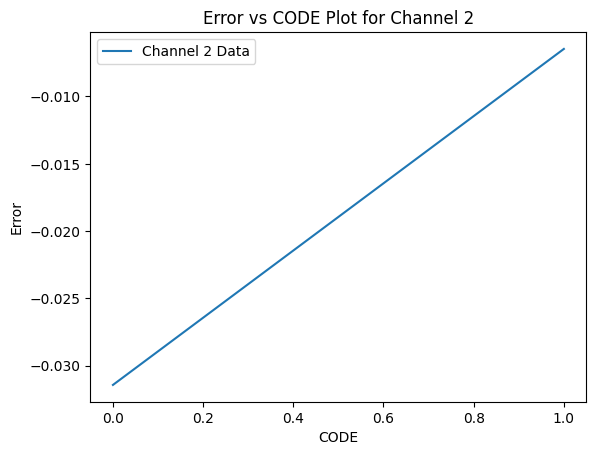

3
Writing data 0: 0
Measurement outputs : -11.2296
Expected Output : -11.249923706054688
Writing data 65535: 65535
Measurement outputs : 11.2486
Expected Output : 11.249732971191406

Data stored in DataFrame:
    CODE  VOUT - EXPECTED  VOUT-RESULT     Error
0      0       -11.249924     -11.2296 -0.020324
1  65535        11.249733      11.2486  0.001133


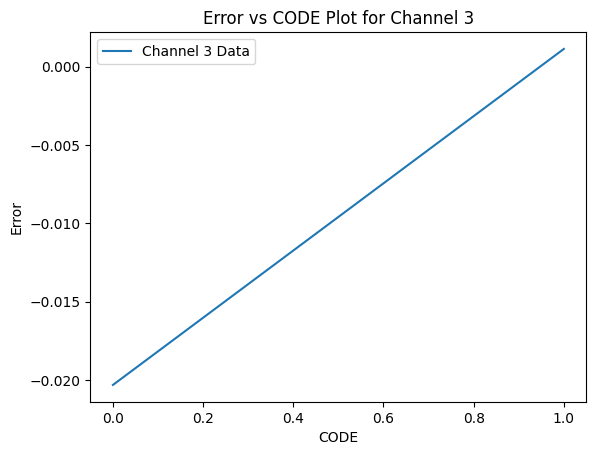


New DataFrame containing values of all four previous DataFrames:
    CODE  VOUT - EXPECTED  VOUT-RESULT     Error
0      0       -11.249924     -11.2265 -0.023424
1  65535        11.249733      11.2499 -0.000167
0      0       -11.249924     -11.2418 -0.008124
1  65535        11.249733      11.2436  0.006133
0      0       -11.249924     -11.2185 -0.031424
1  65535        11.249733      11.2562 -0.006467
0      0       -11.249924     -11.2296 -0.020324
1  65535        11.249733      11.2486  0.001133


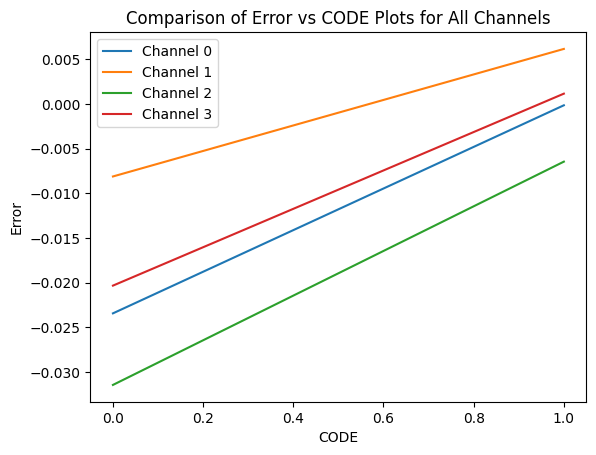

In [2]:
from keithley2600 import Keithley2600
from pmu_som import communicator, pmu_ctrl, pmu_cal
from time import sleep
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd


try:
    del(p.c)
except:
    pass

k = Keithley2600('GPIB0::17::INSTR', visa_library='')
#k.smua.source.output = k.smua.OUTPUT_OFF

k.smua.reset()
k.smub.reset()

# p = communicator.communicator(False)
p = pmu_ctrl.pmu()

### all channels of PMU turnoff

for channel in p.channels:
    channel.change_pmu_reg({"CH EN": 0})
p.decode_pmu_reg()

## SMU and PMU Setup

p.write_all_PMU_REGS(0x1E060)

k.display.screen            = k.display.SMUA
k.display.smua.measure.func = k.display.MEASURE_DCVOLTS
    
k.smua.measure.rangev       = 20
k.smua.measure.autorangei   = k.smua.AUTORANGE_ON
#k.smua.measure.autorangev   = k.smua.AUTORANGE_ON
k.smua.measure.nplc         = 1    
k.smua.source.func          = k.smua.OUTPUT_DCAMPS
k.smua.source.leveli        = 0
k.smua.source.limiti        = 1e-3
k.smua.source.limitv        = 20
k.smua.source.output        = k.smua.OUTPUT_ON

p.change_sys_ctrl({
        "DUTGND/CH" : 1,
        "INT10K"    : 1,
        "GAIN"      : 2,
        "TMP ENABLE": 1,
        "TMP"       : 3 # Thermal shutdown at 100°C
    })

p.decode_pmu_reg()

for ch in range(4):
    p.channels[ch].change_pmu_reg({

    "SS0"   : 0,
    "SF0"   : 0  #1,1

    })
p.decode_sys_ctrl()

import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to store individual DataFrames
all_dataframes = []

# Add for loop for ch
for ch in range(4):
    print(ch)
  #  p.write_all_PMU_REGS(0x21fc60)
    
    #p.channels[ch].change_pmu_reg = 0x21fc60
    
    #Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "CH EN": 1,      # Channel enable
        "FORCE": 0,      # FV
        "C": 3,
        "MEAS": 3,       # VSens
        "SS0": 1,
        "SF0": 1,        # 1,1
        "FIN": 1
    })
        
    # Enable beeper and play chord
    k.beeper.enable = k.beeper.ON
    k.play_chord(notes=("G6", "F6", "C6", "C6"), durations=0.1)
    k.beeper.enable = k.beeper.OFF
    k.smua.source.output = k.smua.OUTPUT_ON

    data_list = []
    measure_points = (0, 0xFFFF)
    

    # Calculate the step size to generate 20 equidistant data points
   # step_size = 0xFFFF // 19

    # Loop to generate and write equidistant data points
    for d in  measure_points:
        # Calculate the data value for the current index
       # data = i * step_size

        # Print the data being written to the DAC register
        print(f"Writing data {d }: {(d)}")

        # Write the data to the DAC register
        p.channels[ch].write_dac(
            data=round(d),
            dac_reg="FIN_U",
            reg="X1"
        )

        # Perform measurement after writing to the DAC register
        sleep(2)

        iv_data = k.smua.measure.v()
        V_REF = 5

        # Print the measurement outputs
        print(f"Measurement outputs : {iv_data}")

        # Calculate expected output and error
      
        VOUT = ((4.5 * d) - (3.5 * 42130)) * (V_REF / (2**16))
        error = VOUT - iv_data
        print(f"Expected Output : {VOUT}")

        # Append data to the list
        data_list.append({"CODE": (d), "VOUT - EXPECTED": VOUT, "VOUT-RESULT": iv_data, "Error": error})

    # Create a DataFrame for the current channel
    data_df = pd.DataFrame(data_list)

    # Append the DataFrame to the list of all DataFrames
    all_dataframes.append(data_df)

    # Display the DataFrame
    print("\nData stored in DataFrame:")
    print(data_df)

    # Plot the data for the current channel
    plt.plot(data_df.index, data_df["Error"], label=f"Channel {ch} Data", linestyle='-')

    # Add legend and labels
    plt.xlabel("CODE")
    plt.ylabel("Error")
    plt.title(f"Error vs CODE Plot for Channel {ch}")
    plt.legend()

    # Show the plot
    plt.show()
    k.smua.source.output = k.smua.OUTPUT_OFF
    p.channels[ch].change_pmu_reg({
        "CH EN": 0
        })



    

    # Change PMU register settings for the current channel
    p.channels[ch].change_pmu_reg({
        "SS0": 0,
        "SF0": 0,
    })
    
    sleep(2)
    

# Concatenate all individual DataFrames into a single DataFrame
all_data_df = pd.concat(all_dataframes)

# Display the new DataFrame
print("\nNew DataFrame containing values of all four previous DataFrames:")
print(all_data_df)

# Plot comparing all the other four plots
for df in all_dataframes:
    plt.plot(df.index, df["Error"], linestyle='-')

# Add legend and labels
plt.xlabel("CODE")
plt.ylabel("Error")
plt.title("Comparison of Error vs CODE Plots for All Channels")
plt.legend([f"Channel {i}" for i in range(4)])
